## Feedforward Multilayer Neural Network

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a two layer (one hidden and one output) neural network using the sigmoid activation function.

http://cs231n.github.io/neural-networks-case-study/#net is a good resource for this though note they setup the problem slightly differently and use a different activation function. Use it for help working out the gradients which requires some careful work.

Some initial imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import preprocessing

import numpy as np

digits = load_digits()

def one_hot(n_classes, y):
    return np.eye(n_classes)[y]


data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')


X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Normalise the images
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_test = one_hot(10, y_test)
Y_train = one_hot(10, y_train)

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Plot both the sigmoid and its derivative and compare it to wikipedia or wolframalpha.

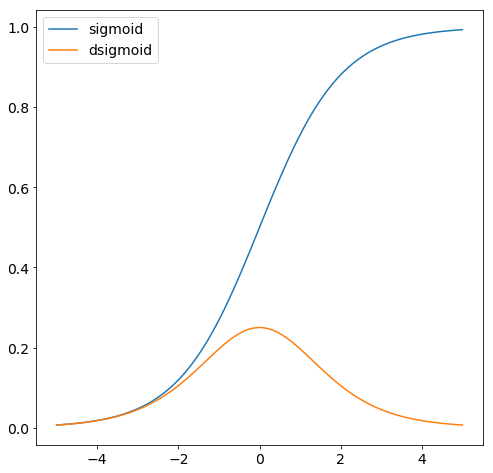

In [5]:
def sigmoid(X):
    return 1/(1+np.exp(-X))


def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer, similar to what we discussed in the slides:
  - $h = sigmoid(\mathbf{W}^h x + b^h)$
  - $y = softmax(\mathbf{W}^o h + b^o)$

Notes: 
  - try to keep the code as similar as possible as for `LogisticRegression`;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- update the grad function to compute all gradients; check that the gradients are well defined;

- implement the `train` and `loss` functions.
- for efficiency reasons we need to compute the gradients analytically but we can compare our results to those of a numerical computation to check we got it right: http://cs231n.github.io/optimization-1/#gradcompute pretty helpful in debugging. Use it on small sub-expressions to build up the complete gradient expression

Bonus: reimplementing all from scratch without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [6]:
# some useful functions from before
EPSILON = 1e-8

def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [53]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o =np.zeros(output_size)
        self.output_size = output_size
        
    def forward(self, X):
        # h=sigmoid(Whx+bh)
        # y=softmax(Woh+bo)
        return self.forward_keep_activations(X)
    
    def forward_keep_activations(self, X):
        # compute the forward step and return intermediate results as well
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h
    
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # compute the gradient of sample x with respect to the two Ws and bs        
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        print(grads)
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [54]:
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

What do things look like before training?

In [55]:
model.loss(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


nan

In [44]:
model.accuracy(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


0.0

In [ ]:
sample_idx = 0
plt.plot(model.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(model.predict(X_train[sample_idx]))

In [ ]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
    
# rerun the notebook without normalising/scaling the images and performance will be worse

96% testing accuracy! Not bad.

In [ ]:
plt.plot(losses)
plt.title("Training loss");

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

## Exercises

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- the current implementations of the `train` and `grad_loss` functions currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,


### Performance

- can you get to 97% accuracy by tweaking the hyper-parameters?

### Momentum

- (bonus) Implement a optimizer with momentum

---


## Build up your intuition

What is the minimal number of neurons and layers needed to classify the circle dataset defined below?

What is the smallest NN to solve the spiral dataset defined below?

In each case can you visualise what the network is doing? Can you explain why your answer is the answer?

Take a look at https://github.com/wildtreetech/advanced-comp-2017/blob/master/03-neural-networks/neural-network-transformations.ipynb to get you started on answering the "why".

In [ ]:
def make_spiral():
    N = 100 # number of points per class
    K = 3 # number of classes
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

In [ ]:
from sklearn.datasets import make_circles

def make_circle_data():
    X, y = make_circles(n_samples=400, factor=.3, noise=.1)
    labels = ['b', 'r']
    y = np.take(labels, (y < 0.5))
    return X, y